In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

In [2]:
#code from chapter 2; repeated here to create needed objects
neighborhoods = gpd.read_file('./datasets/Neighborhood Association Boundaries (GIS).geojson')
art = pd.read_csv('./datasets/public_art.csv')
art.columns = ['title', 'last_name', 'first_name', 'address', 'medium', 'type', 'desc', 'lat', 'lng', 'loc']
art['geometry'] = art.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
art = gpd.GeoDataFrame(art, crs = neighborhoods.crs, geometry = art['geometry'])
neighborhood_art = gpd.sjoin(art, neighborhoods, op = 'within')

### 3.1 Video recapping/refining our motivating task, including the fact that we only need the parts of the data that pertain to the Urban Residents' artworks and a review of how we can plot a polygon and then the points within that polygon

#### The neighborhood_art is in the workspace; we'll subset it to just the 'Urban Residents' art and look at the first few rows with .head()

In [3]:
urban_art = neighborhood_art.loc[neighborhood_art.name == 'Urban Residents']
urban_art.head()

,title,last_name,first_name,address,medium,type,desc,lat,lng,loc,geometry,index_right,name
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)",POINT (-86.77774000000001 36.16234),41,Urban Residents
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
21,Chet Atkins,Faxon,Russell,"Corner of Fifth Avenue North and Union Street,...",Bronze stool and guitar on a granite plynth,Sculpture,A sculpture of a young Chet Atkins seated on a...,36.16466,-86.78102,"(36.16466, -86.78102)",POINT (-86.78102 36.16466),41,Urban Residents
22,Children's Chairs For The Seasons,McGraw,Deloss,"615 Church Street, Nashville TN",Mixed Media - wood and paint,Furniture,chairs depicting the four seasons,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
34,Foliated Scroll,Bloomer,Kent,"615 Church Street, Nashville TN",Aluminum,Frieze,a contemporary adaptation of a classical folia...,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents


#### Next we'll get just the 'Urban Residents' polygon from the neighborhoods data and take a look at it

In [4]:
urban_polygon = neighborhoods.loc[neighborhoods.name == 'Urban Residents']
urban_polygon.head() 

,name,geometry
index_right,,
41,Urban Residents,(POLYGON ((-86.78122053774267 36.1645653773768...


#### Let's go ahead and plot the Urban Residents Neighborhood and add our public art. We'll color the points it by the type of art.

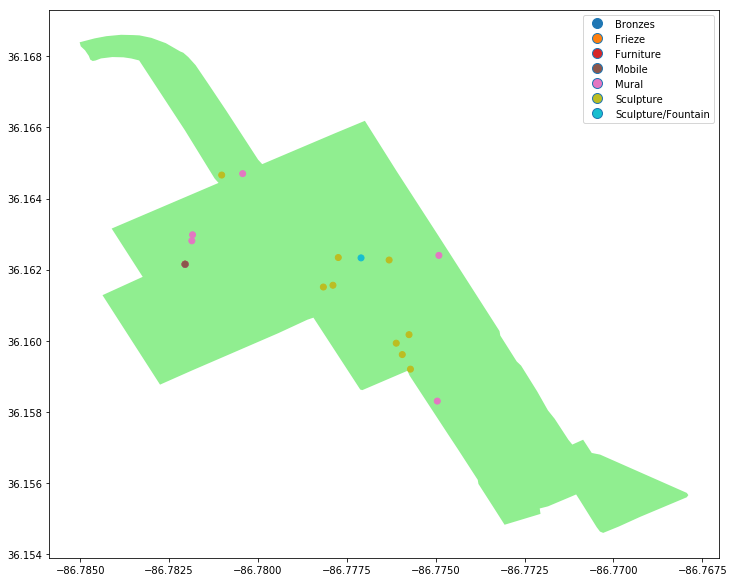

In [5]:
ax = urban_polygon.plot(figsize = (12, 12), color = 'lightgreen')
urban_art.plot( ax = ax, column = 'type', legend = True);
plt.show();

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

### 3.2 Video introducing folium maps and finding the center of a polygon with geopandas geometry.centroid

#### Our folium map wants a center point for the street map. We'll make use of a geopandas geometry property (.centroid) which gives us the center of a polygon.

In [6]:
#find the center of our urban_polygon and look at it
urban_polygon.geometry.centroid


index_right
41    POINT (-86.77756457127047 36.16127820928791)
dtype: object

#### We'll copy the longitude and latitude from urban center to the location of our folium map call. A zoom level of 15 should get us nice and close.

In [7]:
#create our map of Nashville and show it
map_downtown = folium.Map(location =  [36.16127820928791, -86.77756457127047], zoom_start = 15)
map_downtown

### 3.3 Multiple choice exercise

### 3.4 Putting it all together to create a walkable map of downtown art and troubleshooting when things don't go right!!

#### Let's add our Urban Residents neighborhood polygon and art markers.

In [14]:
for (i, row) in enumerate(urban_art.iterrows()):
    row_values = row[1]
    print(row_values)

title              [Fourth and Commerce Sculpture]
last_name                                   Walker
first_name                                     Lin
address          333 Commerce Street, Nashville TN
medium                                         NaN
type                                     Sculpture
desc                                           NaN
lat                                        36.1623
lng                                       -86.7777
loc                          (36.16234, -86.77774)
geometry       POINT (-86.77774000000001 36.16234)
index_right                                     41
name                               Urban Residents
Name: 1, dtype: object
title                                       A Story of Nashville
last_name                                                 Ridley
first_name                                                  Greg
address                          615 Church Street, Nashville TN
medium                                  Hammered coppe

In [15]:
#draw our neighborhood: Urban Residents
folium.GeoJson(urban_polygon).add_to(map_downtown)

#iterate through our urban art to create markers for each piece
#here lat is listed first!!
#also the apostrophe in the 4th row causes problems!

for (i, row) in enumerate(urban_art.iterrows()):
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
    popup = (str(row_values['title']) + ': ' + str(row_values['type'])).replace("'", "`")
    #popup = "there's a quote in this" + str(row_values['type'])
    marker = folium.Marker(location = location, popup = popup)
    
    marker.add_to(map_downtown)

#display our map
map_downtown

In [12]:
urban_art.head()

,title,last_name,first_name,address,medium,type,desc,lat,lng,loc,geometry,index_right,name
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)",POINT (-86.77774000000001 36.16234),41,Urban Residents
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
21,Chet Atkins,Faxon,Russell,"Corner of Fifth Avenue North and Union Street,...",Bronze stool and guitar on a granite plynth,Sculpture,A sculpture of a young Chet Atkins seated on a...,36.16466,-86.78102,"(36.16466, -86.78102)",POINT (-86.78102 36.16466),41,Urban Residents
22,Children's Chairs For The Seasons,McGraw,Deloss,"615 Church Street, Nashville TN",Mixed Media - wood and paint,Furniture,chairs depicting the four seasons,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
34,Foliated Scroll,Bloomer,Kent,"615 Church Street, Nashville TN",Aluminum,Frieze,a contemporary adaptation of a classical folia...,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
